In [1]:
import numpy as np
import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from susy_qm import calculate_Hamiltonian

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os

8 DW


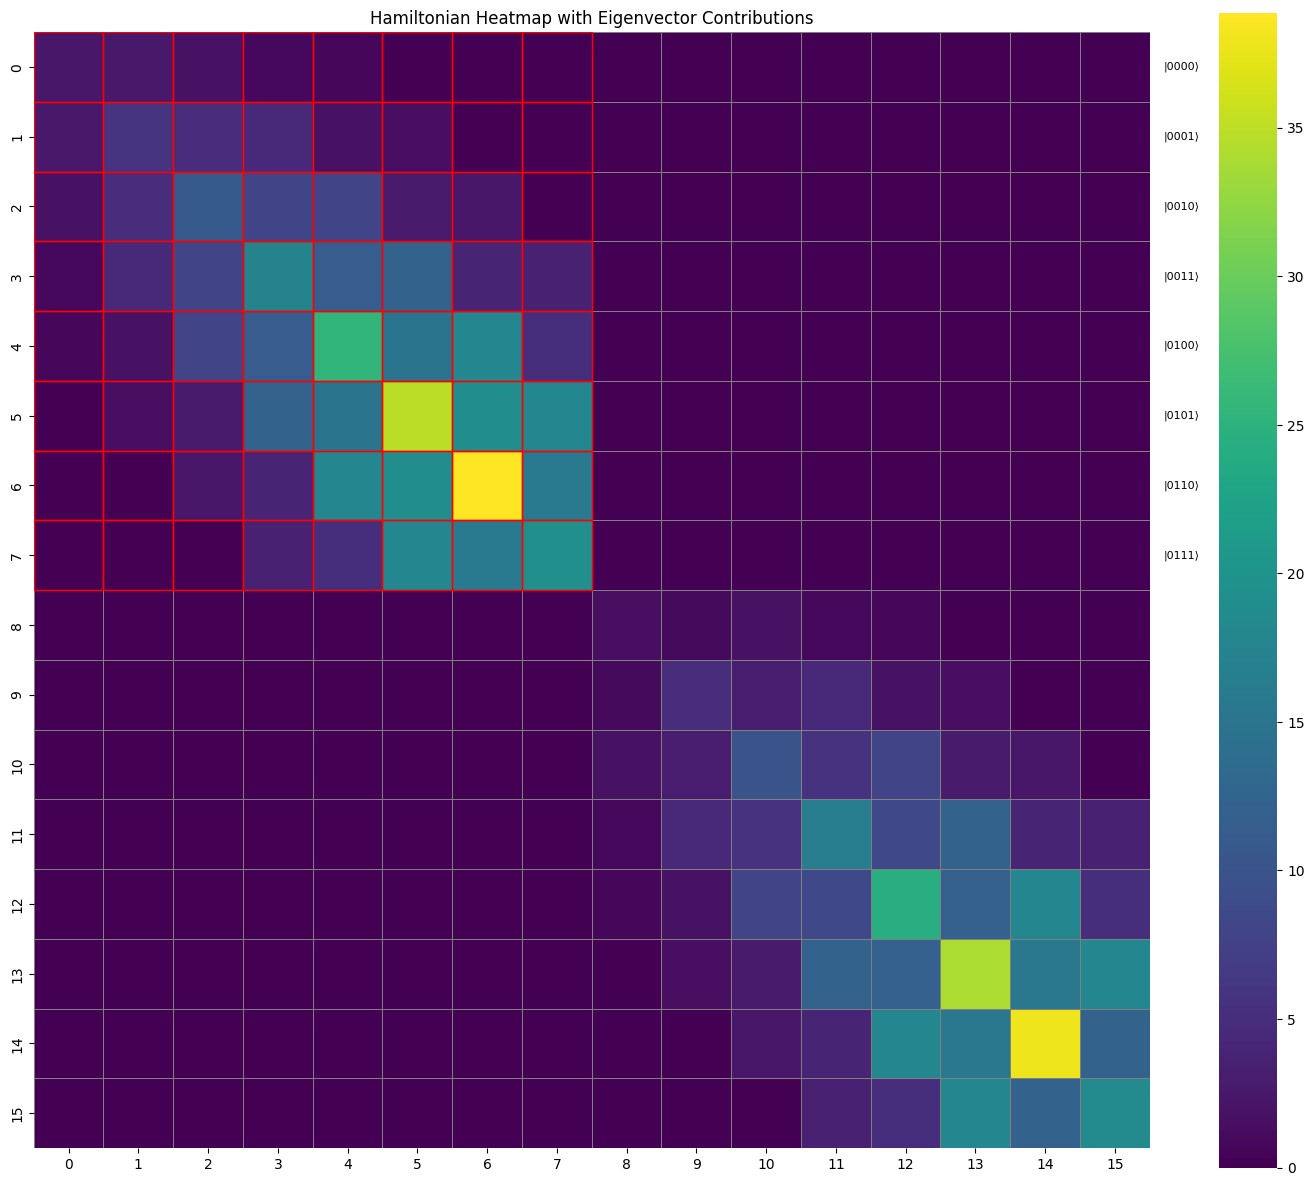

In [2]:
potential = 'DW'
cutoffs = [8]

for cutoff in cutoffs:

    print(cutoff, potential)
    H = calculate_Hamiltonian(cutoff, potential)
    hamiltonian = SparsePauliOp.from_operator(H)
    num_qubits = hamiltonian.num_qubits
        
    eigenvalues, eigenvectors = np.linalg.eig(H)
    min_3_ev = eigenvalues.argsort()[:4]
    min_eigenvector = np.asarray(eigenvectors[:, min_3_ev[0]])

    df = pd.DataFrame(H.real)
    active_indices = [i for i, val in enumerate(min_eigenvector) if abs(val) > 1e-8]

    plt.figure(figsize=(18, 15))
    ax = sns.heatmap(df, cmap='viridis', cbar=True, annot=False, linewidths=0.5, linecolor='gray', square=True)

    for i in active_indices:
        for j in active_indices:
            rect = patches.Rectangle(
                (j, i), 1, 1, fill=False, edgecolor='red', linewidth=1
            )
            ax.add_patch(rect)

    eigvec = min_eigenvector.real.flatten()
    #for i in range(len(eigvec)):
    for i in active_indices:
        basis = format(i, f'0{num_qubits}b')
        label = f"|{basis}⟩"#: {eigvec[i].real:.2f}"
        ax.text(df.shape[1] + 0.2, i + 0.5, label, va='center', ha='left', color='black', fontsize=8)

    plt.title("Hamiltonian Heatmap with Eigenvector Contributions")
    plt.show()


    #save_path = os.path.join(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\Wess-Zumino\EigenvectorChecks\Heatmaps\BasisStates", boundary_condition, potential, folder)
    #os.makedirs(save_path, exist_ok=True)
    #plt.savefig(save_path + f"\\heatmap_{cutoff}")


In [6]:
amplitudes = np.abs(min_eigenvector)

# Binary labels for 4-qubit basis states
num_qubits = 4
labels = [format(i, f'0{num_qubits}b') for i in range(len(min_eigenvector))]

# Only show non-zero entries (Qiskit does this too)
threshold = 1e-8
nonzero = amplitudes > threshold

# Display like Qiskit's bar plot
for label, amp in zip(np.array(labels)[nonzero], amplitudes[nonzero]):
    print(f"|{label}⟩: {amp:.6f}")

|0000⟩: 0.788093
|0001⟩: 0.582016
|0010⟩: 0.139331
|0011⟩: 0.089479
|0100⟩: 0.094664
|0101⟩: 0.027618
|0110⟩: 0.031541
|0111⟩: 0.045047


In [21]:
potential = 'DW'

In [22]:
cutoffs = [2]
for cutoff in cutoffs:
    print(cutoff, potential)
    H = calculate_Hamiltonian(cutoff, potential)
    hamiltonian = SparsePauliOp.from_operator(H)
    num_qubits = hamiltonian.num_qubits
        
    eigenvalues, eigenvectors = np.linalg.eig(H)
    min_eigenvalue = min(eigenvalues.real)
    min_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_index]

    min_3_ev = eigenvalues.argsort()[:3]
    min_eigenvector = np.asarray(eigenvectors[:, min_3_ev[0]])

    active_indices = [i for i, val in enumerate(min_eigenvector) if abs(val) > 1e-8]
    states = [format(i, f'0{num_qubits}b') for i in active_indices]
    print("Active basis states:")
    for s in states:
        print(s)

    print('##########################################')

2 DW
Active basis states:
00
01
##########################################


In [23]:
def highlight_nonzero(val):
    return 'background-color: green' if val != 0 else ''

df = pd.DataFrame(H.real)
df = df.style.map(highlight_nonzero).format(precision=1)
df


,0,1,2,3
0,2.1,1.8,0.0,0.0
1,1.8,2.1,0.0,0.0
2,0.0,0.0,1.1,0.4
3,0.0,0.0,0.4,1.1


In [13]:
active_indices = [i for i, val in enumerate(min_eigenvector) if abs(val) > 1e-8]
df = pd.DataFrame(H.real)

def highlight_active_contribution(val, row_idx, col_idx):
    if row_idx in active_indices and col_idx in active_indices:
        return 'background-color: green'
    return ''

styled_df = df.style.apply(
    lambda data: np.vectorize(highlight_active_contribution)(data, *np.indices(data.shape)),
    axis=None
).format("{:.1f}")

styled_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2.4,2.5,1.8,0.9,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.5,5.9,5.0,4.3,1.7,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.8,5.0,10.9,8.0,7.8,2.7,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.9,4.3,8.0,17.4,11.3,12.3,3.9,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6,1.7,7.8,11.3,25.4,15.0,17.8,5.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.4,2.7,12.3,15.0,34.9,19.1,17.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,2.4,3.9,17.8,19.1,38.9,15.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,3.6,5.1,17.8,15.9,19.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,1.1,1.8,0.9,0.6,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,4.9,3.0,4.3,1.7,1.4,0.0,0.0


In [6]:
states = [format(i, f'0{num_qubits}b') for i in active_indices]
print("Active basis states:")
for s in states:
    print(s)



Active basis states:
00
01
